In [25]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


In [48]:
# #Loading Data set
forestfires = pd.read_csv("../datasets/forestfires.csv", sep=',')

#Columns/Features
numeric_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
categorical_features = ['month', 'day']
target = 'area'

forestfires['logArea'] = np.log1p(forestfires[target])

print("Data: shape=", forestfires.shape)
print(forestfires.head())


Data: shape= (517, 14)
   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  \
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0   
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0   
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0   
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0   
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0   

   logArea  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  


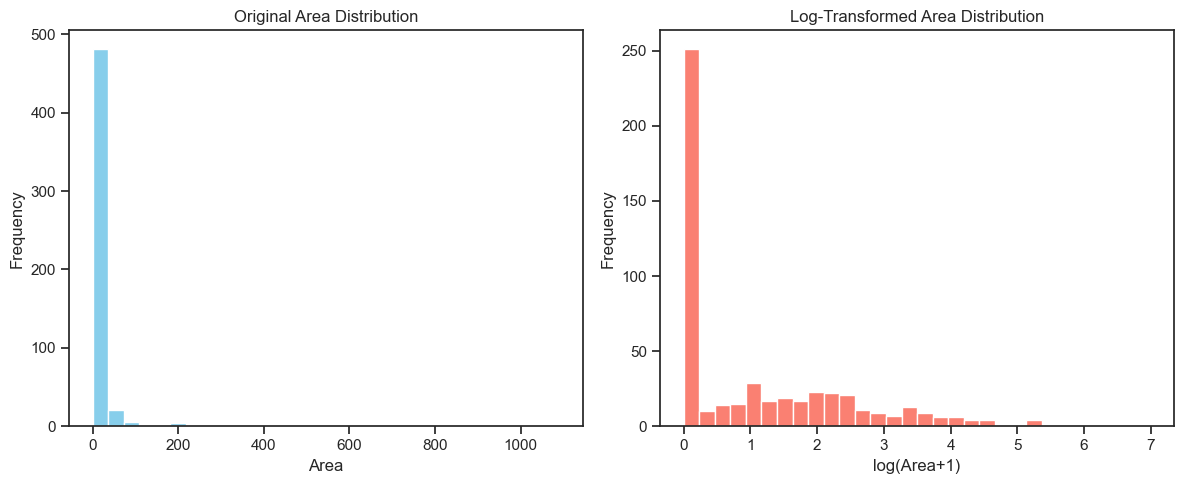

   X  Y  FFMC   DMC     DC  ISI  temp  RH  wind  rain month  day
0  7  5  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   mar  fri
1  7  4  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   oct  tue
2  7  4  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   oct  sat
3  8  6  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   mar  fri
4  8  6  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   mar  sun


In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X = forestfires[numeric_features + categorical_features]
y = forestfires['logArea']

# print(X.head())
# print(y.head())

# Graphing original vs log area distributions in dataset
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(forestfires[target], bins=30, color='skyblue')
plt.title("Original Area Distribution")
plt.xlabel("Area")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(y, bins=30, color='salmon')
plt.title("Log-Transformed Area Distribution")
plt.xlabel("log(Area+1)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

print(X.head())

Best k: 20 with RMSE: 1.1900
Variance of RMSE: 0.0024
average RMSE: 1.2206


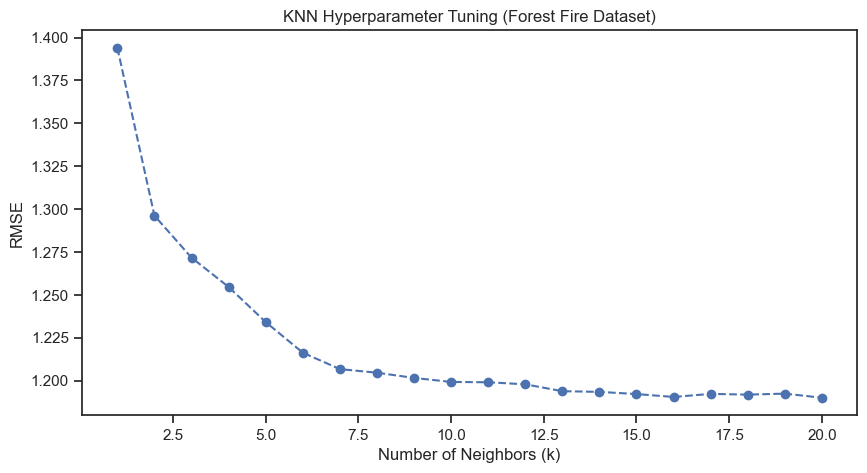

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store RMSE for each fold
rmse_scores = []

best_k = None
best_rmse = float('inf')

for k in range(1, 21):  # Tuning from k=1 to 20
    fold_rmse = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Define KNN pipeline
        knn_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('knn', KNeighborsRegressor(n_neighbors=k))
        ])

        # Train pipeline
        knn_pipeline.fit(X_train, y_train)

        # Predict and compute RMSE
        y_pred = knn_pipeline.predict(X_test)
        rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
        fold_rmse.append(rmse)

    avg_rmse = np.mean(fold_rmse)
    rmse_scores.append(avg_rmse)

    # Track best k value
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_k = k

print(f"Best k: {best_k} with RMSE: {best_rmse:.4f}")
print(f"Variance of RMSE: {np.var(rmse_scores):.4f}")
print(f"average RMSE: {np.mean(rmse_scores):.4f}")

# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), rmse_scores, marker='o', linestyle='dashed')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.title('KNN Hyperparameter Tuning (Forest Fire Dataset)')
plt.show()



Best max_depth: 1 with RMSE: 1.1806
Average RMSE: 1.3420
Variance of RMSE: 0.0072


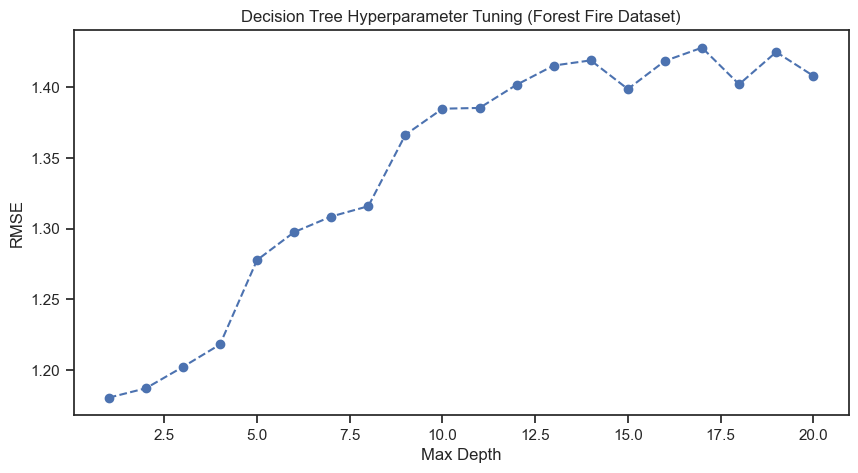

In [7]:
#Decision Trees
from sklearn.tree import DecisionTreeRegressor
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store RMSE for each fold
rmse_scores = []

# Try different values for max_depth to tune DecisionTreeRegressor
best_depth = None
best_rmse = float('inf')
depth_range = range(1, 21)  # Tuning max_depth from 1 to 20

for depth in depth_range:
    fold_rmse = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Define Decision Tree pipeline
        dt_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('dt', DecisionTreeRegressor(max_depth=depth, random_state=42))
        ])

        # Train pipeline
        dt_pipeline.fit(X_train, y_train)

        # Predict and compute RMSE
        y_pred = dt_pipeline.predict(X_test)
        rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))  
        fold_rmse.append(rmse)

    avg_rmse = np.mean(fold_rmse)
    rmse_scores.append(avg_rmse)

    # Track best max_depth value
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_depth = depth

# Print analysis
print(f"Best max_depth: {best_depth} with RMSE: {best_rmse:.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Variance of RMSE: {np.var(rmse_scores):.4f}")

# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(depth_range, rmse_scores, marker='o', linestyle='dashed')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Decision Tree Hyperparameter Tuning (Forest Fire Dataset)')
plt.show()


Best n_estimators: 300 with RMSE: 1.2078
Average RMSE: 1.2140
Variance of RMSE: 0.0001


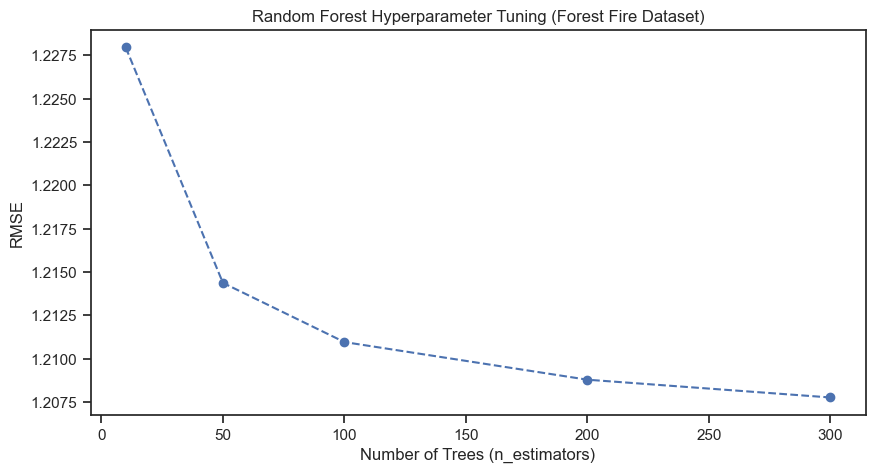

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store RMSE for each fold
rmse_scores = []

# Try different values for n_estimators (number of trees) to tune RandomForestRegressor
best_n = None
best_rmse = float('inf')
n_estimators_range = [10, 50, 100, 200, 300]  # Tuning different tree counts

for n in n_estimators_range:
    fold_rmse = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Define Random Forest pipeline
        rf_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('rf', RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1))
        ])

        # Train pipeline
        rf_pipeline.fit(X_train, y_train)

        # Predict and compute RMSE
        y_pred = rf_pipeline.predict(X_test)
        rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))  
        fold_rmse.append(rmse)

    avg_rmse = np.mean(fold_rmse)
    rmse_scores.append(avg_rmse)

    # Track best n_estimators value
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_n = n

# Print analysis
print(f"Best n_estimators: {best_n} with RMSE: {best_rmse:.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Variance of RMSE: {np.var(rmse_scores):.4f}")

# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, rmse_scores, marker='o', linestyle='dashed')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Random Forest Hyperparameter Tuning (Forest Fire Dataset)')
plt.show()

Best n_estimators: 10 with RMSE: 1.1821
Average RMSE: 1.2214
Variance of RMSE: 0.0008


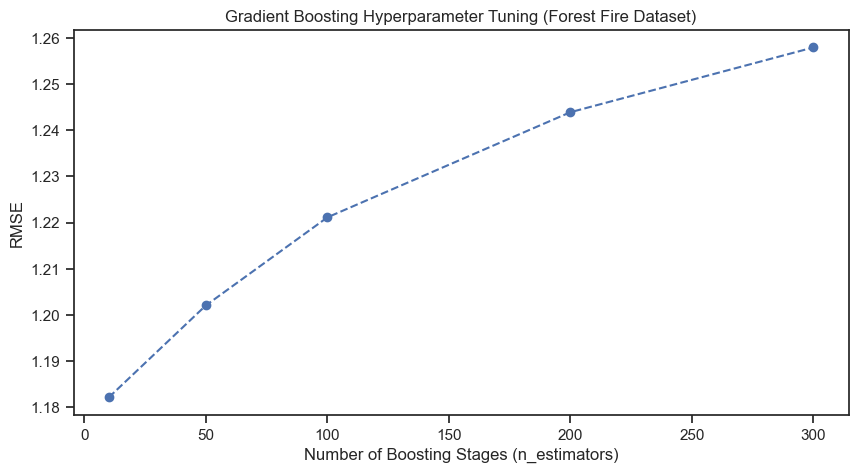

In [54]:
#Gradient Tree Boosting
from sklearn.ensemble import GradientBoostingRegressor

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store RMSE for each fold
rmse_scores = []

# Try different values for n_estimators (number of boosting stages) to tune GradientBoostingRegressor
best_n = None
best_rmse = float('inf')
n_estimators_range = [10, 50, 100, 200, 300]  # Tuning different boosting stages

for n in n_estimators_range:
    fold_rmse = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Define Gradient Boosting pipeline
        gbr_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('gbr', GradientBoostingRegressor(n_estimators=n, random_state=42))
        ])

        # Train pipeline
        gbr_pipeline.fit(X_train, y_train)

        # Predict and compute RMSE
        y_pred = gbr_pipeline.predict(X_test)
        rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))  
        fold_rmse.append(rmse)

    avg_rmse = np.mean(fold_rmse)
    rmse_scores.append(avg_rmse)

    # Track best n_estimators value
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_n = n

# Print analysis
print(f"Best n_estimators: {best_n} with RMSE: {best_rmse:.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Variance of RMSE: {np.var(rmse_scores):.4f}")

# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, rmse_scores, marker='o', linestyle='dashed')
plt.xlabel('Number of Boosting Stages (n_estimators)')
plt.ylabel('RMSE')
plt.title('Gradient Boosting Hyperparameter Tuning (Forest Fire Dataset)')
plt.show()

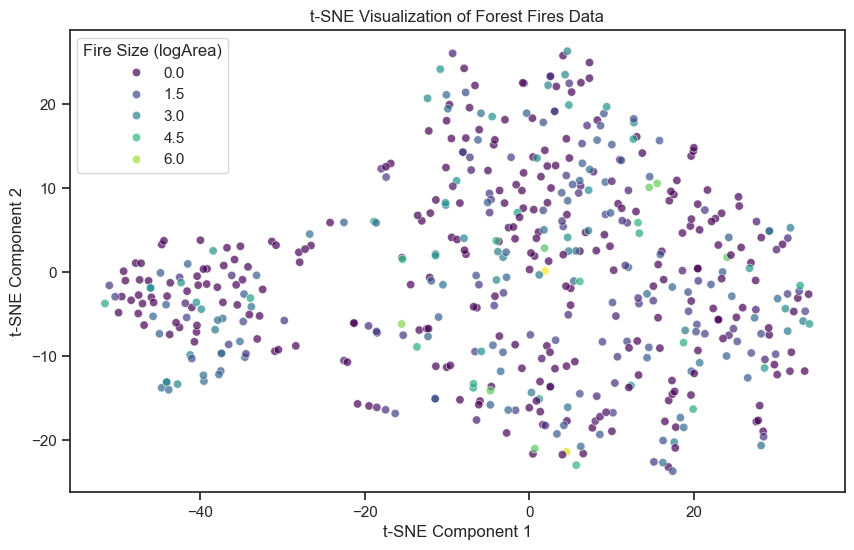

In [ ]:
#3.1 t-sne 
from sklearn.manifold import TSNE

# Ensure preprocessor is applied before t-SNE
X_transformed = preprocessor.fit_transform(X)

# Run t-SNE to reduce dataset to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)  # Adjust perplexity if needed
X_tsne = tsne.fit_transform(X_transformed)

# Ensure y has a matching index
y = y.reset_index(drop=True)

# Convert to DataFrame for plotting
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['logArea'] = y

# Create t-SNE scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue=tsne_df['logArea'], palette='viridis', alpha=0.7, data=tsne_df)
plt.title("t-SNE Visualization of Forest Fires Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Fire Size (logArea)")
plt.show()

Explained Variance by PC1: 0.2539
Explained Variance by PC2: 0.1351
Total Explained Variance (PC1 + PC2): 0.3890


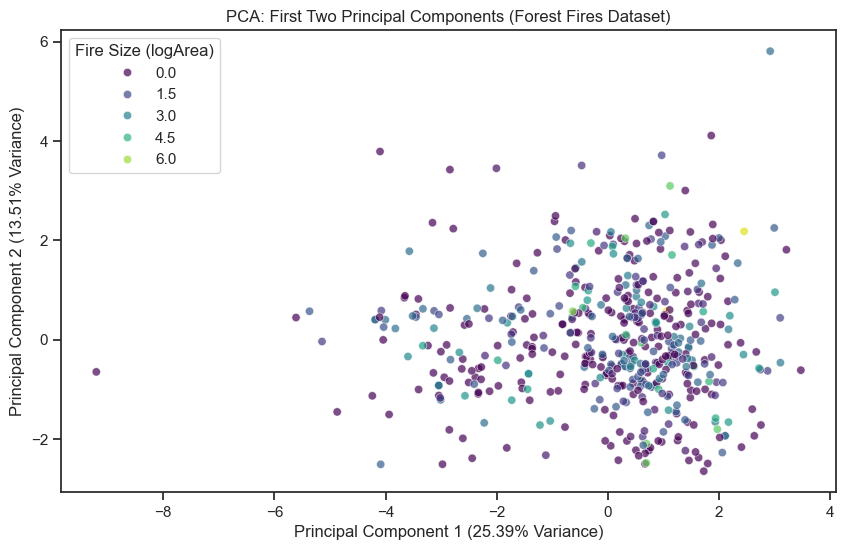

In [ ]:
#3.2 PCA
from sklearn.decomposition import PCA

# Run PCA to extract principal components
pca = PCA(n_components=2)  # Reduce to 2D
X_pca = pca.fit_transform(X_transformed)

# Convert to DataFrame for easier plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['logArea'] = y.reset_index(drop=True)  # Ensure matching index

# Print variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by PC1: {explained_variance[0]:.4f}")
print(f"Explained Variance by PC2: {explained_variance[1]:.4f}")
print(f"Total Explained Variance (PC1 + PC2): {np.sum(explained_variance):.4f}")

# Create PCA scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue=pca_df['logArea'], palette='viridis', alpha=0.7, data=pca_df)
plt.title("PCA: First Two Principal Components (Forest Fires Dataset)")
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% Variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% Variance)")
plt.legend(title="Fire Size (logArea)")
plt.show()

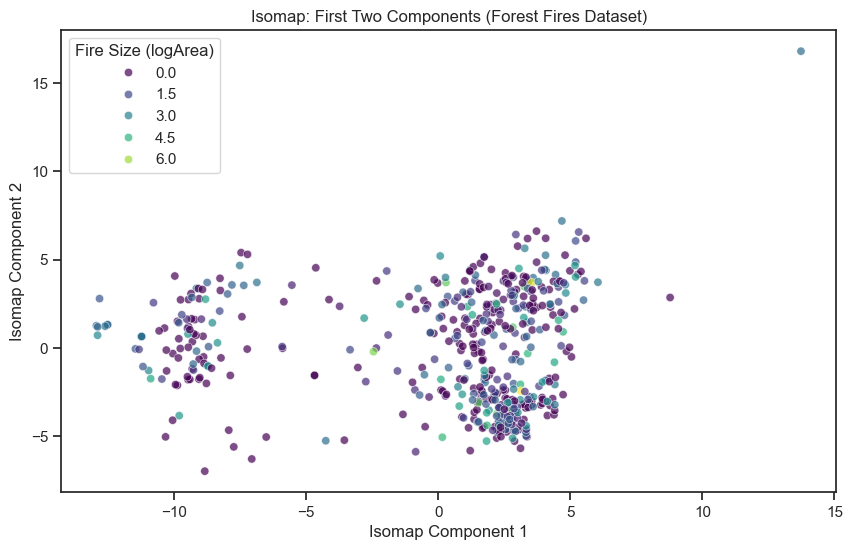

In [30]:
#3.3 Using Isomap
from sklearn.manifold import Isomap

# Apply preprocessor before Isomap
X_transformed = preprocessor.fit_transform(X)

# Run Isomap to extract components
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_transformed)

# Convert to DataFrame for easier plotting
isomap_df = pd.DataFrame(X_isomap, columns=['ISOMAP1', 'ISOMAP2'])
isomap_df['logArea'] = y.reset_index(drop=True)  # Ensure matching index

# Create Isomap scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ISOMAP1', y='ISOMAP2', hue=isomap_df['logArea'], palette='viridis', alpha=0.7, data=isomap_df)
plt.title("Isomap: First Two Components (Forest Fires Dataset)")
plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.legend(title="Fire Size (logArea)")
plt.show()



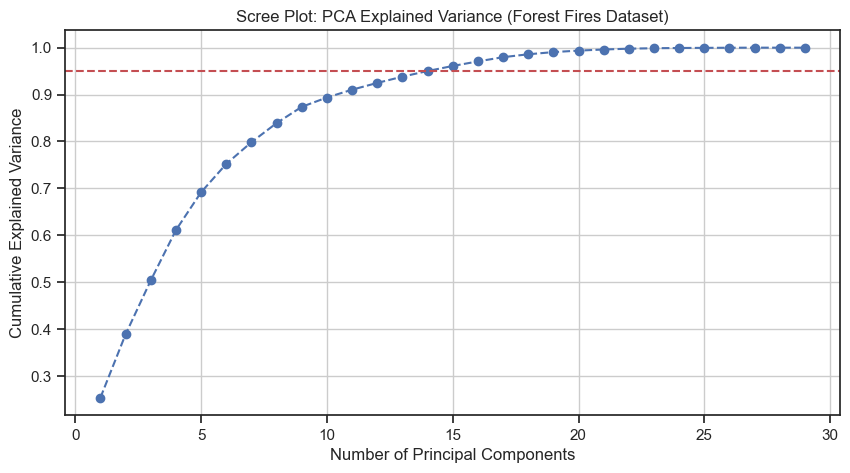

Optimal number of PCA components: 14


In [ ]:
#3.4 scree-plot and new datasets with reduced dimensionality

# Apply preprocessor before PCA & Isomap
X_transformed = preprocessor.fit_transform(X)

# Step 1: Compute PCA on full dataset
pca = PCA()
X_pca_full = pca.fit_transform(X_transformed)

# Step 2: Compute cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Step 3: Scree plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--')  
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot: PCA Explained Variance (Forest Fires Dataset)')
plt.grid()
plt.show()

# Step 4: Determine the best reduced dimension size (~95% variance retention)
best_pca_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of PCA components: {best_pca_components}")

# Step 5: Create PCA-reduced dataset
pca = PCA(n_components=best_pca_components)
X_pca = pca.fit_transform(X_transformed)
forestfires_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(best_pca_components)])
forestfires_pca['logArea'] = y.reset_index(drop=True)

# Step 6: Create Isomap-reduced dataset (same number of components as PCA)
isomap = Isomap(n_components=best_pca_components)
X_isomap = isomap.fit_transform(X_transformed)
forestfires_isomap = pd.DataFrame(X_isomap, columns=[f'ISOMAP{i+1}' for i in range(best_pca_components)])
forestfires_isomap['logArea'] = y.reset_index(drop=True)

# Save the datasets to CSV files for future testing
forestfires_pca.to_csv("../datasets/forestfires-pca.csv", index=False)
forestfires_isomap.to_csv("../datasets/forestfires-isomap.csv", index=False)

In [50]:

# Load preprocessed PCA and Isomap datasets
X_pca = pd.read_csv("../datasets/forestfires-pca.csv", header=0).iloc[:, :-1]  # Exclude target column
X_isomap = pd.read_csv("../datasets/forestfires-isomap.csv", header=0).iloc[:, :-1]  # Exclude target column

datasets = {
    "forestfires": (X, True),  # Standard dataset requires preprocessing
    "forestfires-pca": (X_pca, False),  # PCA-transformed dataset does not need preprocessing
    "forestfires-isomap": (X_isomap, False)  # Isomap-transformed dataset does not need preprocessing
}

# Define models
models = {
    "k-NN": KNeighborsRegressor(n_neighbors=8),
    "RF": RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42),
    "GB": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
}

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

# Iterate over each dataset and model combination
for dataset_name, (X, needs_preprocessing) in datasets.items():
    for model_name, model in models.items():
        fold_rmse = []
        
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            if needs_preprocessing:
                X_train = preprocessor.fit_transform(X_train)
                X_test = preprocessor.transform(X_test)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
            fold_rmse.append(rmse)
        
        avg_rmse = np.mean(fold_rmse)
        results.append([dataset_name, model_name, avg_rmse])

# Convert results to DataFrame and display
results_df = pd.DataFrame(results, columns=["Dataset", "Model", "RMSE"])
display(results_df)


,Dataset,Model,RMSE
0,forestfires,k-NN,1.204615
1,forestfires,RF,1.208515
2,forestfires,GB,1.252492
3,forestfires-pca,k-NN,1.207178
4,forestfires-pca,RF,1.203658
5,forestfires-pca,GB,1.237918
6,forestfires-isomap,k-NN,1.211026
7,forestfires-isomap,RF,1.202987
8,forestfires-isomap,GB,1.213631
